In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
import yfinance as yf
import datetime
from datetime import date
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsmodels.tsa.stattools import adfuller, kpss
%matplotlib inline

In [74]:
aapl = yf.Ticker("^IRX")

## Check stationarity
### Plot an initial time series
##### Reference
##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

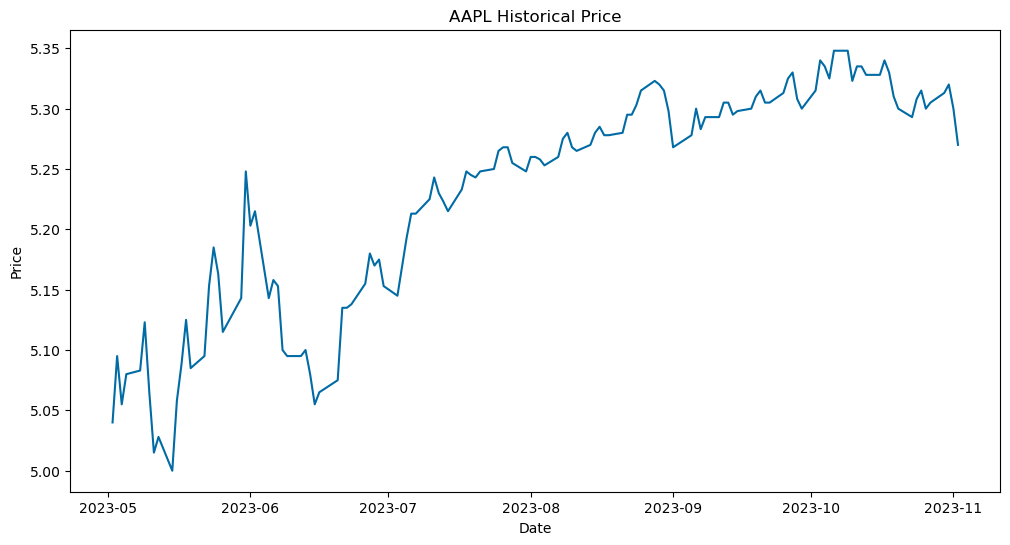

In [75]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='6mo')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AAPL Historical Price')
plt.show()

### Split Price into halves for statistical analysis

In [71]:
X = aapl.history(period='6mo')['Close']
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=233.717968, mean2=243.354062, mean_percent_diff=4.122958
variance1=1786.722358, variance2=393.956971, var_percent_diff=-77.950857


Means are not constant and variances differ significantly. Therefore, series is not stationary.

### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [5]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -2.250306
p-value: 0.188496
Critical Values:
{'1%': -3.4833462346078936, '5%': -2.8847655969877666, '10%': -2.5791564575459813}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [6]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(0.40983113862726867, 0.07291761266066006, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 0.41
p-value: 0.072918
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


##### P-value < .05; therefore, not stationary

### Transform into stationary series

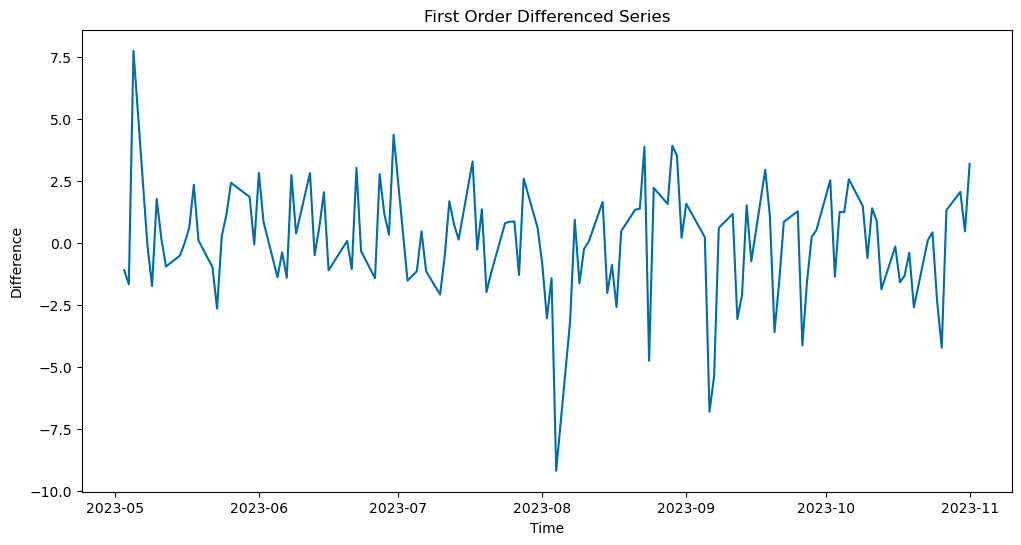

In [7]:
X['Difference'] = X.diff()
plt.figure(figsize=(12,6))
plt.plot(X['Difference'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.show()

In [8]:
result = adfuller(X.Difference.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -9.675769
p-value: 0.000000
Critical Values:
{'1%': -3.4833462346078936, '5%': -2.8847655969877666, '10%': -2.5791564575459813}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

### Smoothing Methods
##### Reference
##### Fuchs, M. (2020). Time series Analysis - smoothing methods. Netlify. https://michael-fuchs-python.netlify.app/2020/10/23/time-series-analysis-smoothing-methods

In [10]:
testX = close.iloc[-30:]
trainX = close.iloc[:-30]

In [12]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')

In [56]:
df = pd.DataFrame()
for i in [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]:
    temp_df = pd.DataFrame()
    print(f'Simple Exponential Smoothing Level {i}')
    fit_v = SimpleExpSmoothing(np.asarray(trainX)).fit(i)
    forecast_prediction_v = fit_v.forecast(len(testX))
    rmse = np.sqrt(metrics.mean_squared_error(testX, forecast_prediction_v))
    temp_df['Smoothing Parameter'] = i
    temp_df['RMSE'].iloc(df.index) = rmse
    print(temp_df)
    #df = pd.concat([df, temp_df], axis=0, ignore_index=False)
    #ts_eval_metrics(testX, forecast_prediction_v)

SyntaxError: cannot assign to function call (430787985.py, line 9)

In [52]:
df_temp

NameError: name 'df_temp' is not defined

In [9]:
aapl.options

('2023-11-03',
 '2023-11-10',
 '2023-11-17',
 '2023-11-24',
 '2023-12-01',
 '2023-12-08',
 '2023-12-15',
 '2024-01-19',
 '2024-02-16',
 '2024-03-15',
 '2024-04-19',
 '2024-06-21',
 '2024-09-20',
 '2024-12-20',
 '2025-01-17',
 '2025-06-20',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16')

In [10]:
opt_df = aapl.option_chain('2023-11-10')
call = opt_df.calls
put = opt_df.puts
put

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL231110P00050000,2023-10-30 17:50:05+00:00,50.0,0.01,0.0,0.00,0.00,0.0,NaN,0.0,1.000005,False,REGULAR,USD
1,AAPL231110P00080000,2023-10-02 16:00:59+00:00,80.0,0.02,0.0,0.01,0.00,0.0,NaN,1.0,1.531252,False,REGULAR,USD
2,AAPL231110P00095000,2023-10-13 18:32:20+00:00,95.0,0.02,0.0,0.00,0.00,0.0,1.0,0.0,0.500005,False,REGULAR,USD
3,AAPL231110P00100000,2023-10-27 18:02:21+00:00,100.0,0.01,0.0,0.00,0.00,0.0,14.0,0.0,0.500005,False,REGULAR,USD
4,AAPL231110P00105000,2023-10-30 15:27:32+00:00,105.0,0.01,0.0,0.00,0.00,0.0,1.0,0.0,0.500005,False,REGULAR,USD
5,AAPL231110P00110000,2023-11-01 18:28:38+00:00,110.0,0.01,0.0,0.00,0.00,0.0,9.0,0.0,0.500005,False,REGULAR,USD
6,AAPL231110P00115000,2023-10-31 17:51:07+00:00,115.0,0.01,0.0,0.00,0.00,0.0,32.0,0.0,0.500005,False,REGULAR,USD
7,AAPL231110P00120000,2023-11-01 18:41:00+00:00,120.0,0.01,0.0,0.00,0.00,0.0,101.0,0.0,0.500005,False,REGULAR,USD
8,AAPL231110P00125000,2023-11-01 14:15:56+00:00,125.0,0.01,0.0,0.00,0.00,0.0,20.0,0.0,0.500005,False,REGULAR,USD
9,AAPL231110P00130000,2023-11-01 18:16:00+00:00,130.0,0.02,0.0,0.00,0.00,0.0,18.0,0.0,0.500005,False,REGULAR,USD


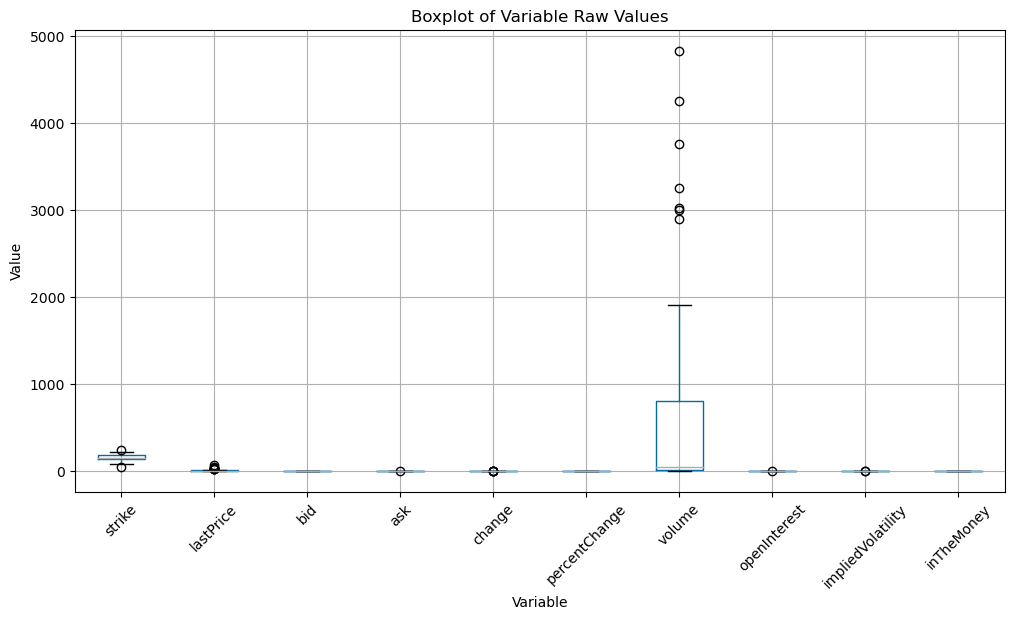

In [11]:
ax = put.boxplot(return_type='axes', rot=45, figsize=(12, 6))
ax.set_xlabel("Variable")
ax.set_ylabel("Value")
ax.set_title("Boxplot of Variable Raw Values")
plt.show()

In [12]:
put.describe()

,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility
count,46.000000,46.000000,41.0,41.000000,46.000000,41.0,38.000000,41.000000,46.000000
mean,154.347826,7.457391,0.0,0.000244,0.005217,0.0,833.973684,0.024390,0.205510
std,37.417742,14.357082,0.0,0.001562,0.015739,0.0,1401.892784,0.156174,0.299484
min,50.000000,0.010000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000
25%,138.250000,0.032500,0.0,0.000000,0.000000,0.0,12.500000,0.000000,0.000010
50%,151.250000,0.145000,0.0,0.000000,0.000000,0.0,50.000000,0.000000,0.093759
75%,179.375000,6.787500,0.0,0.000000,0.000000,0.0,798.500000,0.000000,0.250007
max,245.000000,67.900000,0.0,0.010000,0.070000,0.0,4831.000000,1.000000,1.531252


In [13]:
yf.pdr_override()

y_symbols = ['^GSPC', 'ES=F', 'NQ=F', 'YM=F', '^RUT', '^DJT', '^GDAXI', '^N225', '^SSMI', '^STOXX50E', '^FCHI', '^GSPTSE', '^HSI', '000001.SS', '^KS11', '^NSEI', '^AXJO']
stocks = ['^SPX']

In [14]:
startdate = datetime.datetime(2020,3,16)
today = date.today()
enddate = today

In [15]:
indices = web.get_data_yahoo(y_symbols, start=startdate, end=enddate)
stocks = web.get_data_yahoo(stocks, start=startdate, end=enddate)

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed


In [16]:
stocks

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-16,2508.590088,2562.979980,2380.939941,2386.129883,2386.129883,7805450000
2020-03-17,2425.659912,2553.929932,2367.040039,2529.189941,2529.189941,8370250000
2020-03-18,2436.500000,2453.570068,2280.520020,2398.100098,2398.100098,8799300000
2020-03-19,2393.479980,2466.969971,2319.780029,2409.389893,2409.389893,7956100000
2020-03-20,2431.939941,2453.010010,2295.560059,2304.919922,2304.919922,9053950000
...,...,...,...,...,...,...
2023-10-26,4175.990234,4183.600098,4127.899902,4137.229980,4137.229980,4277640000
2023-10-27,4152.930176,4156.700195,4103.779785,4117.370117,4117.370117,4019500000
2023-10-30,4139.390137,4177.470215,4132.939941,4166.819824,4166.819824,3911140000


In [17]:
aapl.history(period='1mo')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-10-02 00:00:00-04:00,171.220001,174.300003,170.929993,173.750000,52164500,0.0,0.0
2023-10-03 00:00:00-04:00,172.259995,173.630005,170.820007,172.399994,49594600,0.0,0.0
2023-10-04 00:00:00-04:00,171.089996,174.210007,170.970001,173.660004,53020300,0.0,0.0
2023-10-05 00:00:00-04:00,173.789993,175.449997,172.679993,174.910004,48527900,0.0,0.0
2023-10-06 00:00:00-04:00,173.800003,177.990005,173.179993,177.490005,57224100,0.0,0.0
2023-10-09 00:00:00-04:00,176.809998,179.050003,175.800003,178.990005,42390800,0.0,0.0
2023-10-10 00:00:00-04:00,178.100006,179.720001,177.949997,178.389999,43698000,0.0,0.0
2023-10-11 00:00:00-04:00,178.199997,179.850006,177.600006,179.800003,47551100,0.0,0.0
2023-10-12 00:00:00-04:00,180.070007,182.339996,179.039993,180.710007,56743100,0.0,0.0


In [18]:
aapl.get_shares_full(start="2022-01-01", end=None)

2022-01-10 00:00:00-05:00    16334399488
2022-01-31 00:00:00-05:00    16319399936
2022-02-04 00:00:00-05:00    16319399936
2022-02-05 00:00:00-05:00    16319399936
2022-02-11 00:00:00-05:00    16319399936
                                ...     
2023-10-20 00:00:00-04:00    15634199552
2023-10-20 00:00:00-04:00    15668100096
2023-10-22 00:00:00-04:00    15634199552
2023-10-27 00:00:00-04:00    15634199552
2023-10-28 00:00:00-04:00    15634199552
Length: 77, dtype: int64

In [19]:
aapl.income_stmt

,2022-09-30,2021-09-30,2020-09-30
Tax Effect Of Unusual Items,0.0,0.0,0.0
Tax Rate For Calcs,0.162045,0.133023,0.144282
Normalized EBITDA,130541000000.0,120233000000.0,77344000000.0
Net Income From Continuing Operation Net Minority Interest,99803000000.0,94680000000.0,57411000000.0
Reconciled Depreciation,11104000000.0,11284000000.0,11056000000.0
Reconciled Cost Of Revenue,223546000000.0,212981000000.0,169559000000.0
EBITDA,130541000000.0,120233000000.0,77344000000.0
EBIT,119437000000.0,108949000000.0,66288000000.0
Net Interest Income,-106000000.0,198000000.0,890000000.0
Interest Expense,2931000000.0,2645000000.0,2873000000.0


In [20]:
aapl.quarterly_income_stmt

,2023-06-30,2023-03-31,2022-12-31,2022-09-30
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0
Tax Rate For Calcs,0.125456,0.148756,0.157904,0.15963
Normalized EBITDA,26050000000.0,31216000000.0,38932000000.0,27759000000.0
Net Income From Continuing Operation Net Minority Interest,19881000000.0,24160000000.0,29998000000.0,20721000000.0
Reconciled Depreciation,3052000000.0,2898000000.0,2916000000.0,2865000000.0
Reconciled Cost Of Revenue,45384000000.0,52860000000.0,66822000000.0,52051000000.0
EBITDA,26050000000.0,31216000000.0,38932000000.0,27759000000.0
EBIT,22998000000.0,28318000000.0,36016000000.0,24894000000.0
Net Interest Income,-18000000.0,-12000000.0,-135000000.0,-74000000.0
Interest Expense,998000000.0,930000000.0,1003000000.0,827000000.0


In [21]:
aapl.balance_sheet

,2022-09-30,2021-09-30,2020-09-30
Ordinary Shares Number,15943425000.0,16426786000.0,16976763000.0
Share Issued,15943425000.0,16426786000.0,16976763000.0
Net Debt,96423000000.0,89779000000.0,74420000000.0
Total Debt,120069000000.0,124719000000.0,112436000000.0
Tangible Book Value,50672000000.0,63090000000.0,65339000000.0
Invested Capital,170741000000.0,187809000000.0,177775000000.0
Working Capital,-18577000000.0,9355000000.0,38321000000.0
Net Tangible Assets,50672000000.0,63090000000.0,65339000000.0
Common Stock Equity,50672000000.0,63090000000.0,65339000000.0
Total Capitalization,149631000000.0,172196000000.0,164006000000.0


In [22]:
aapl.quarterly_cashflow

,2023-06-30,2023-03-31,2022-12-31,2022-09-30
Free Cash Flow,24287000000.0,25644000000.0,30218000000.0,20838000000.0
Repurchase Of Capital Stock,-17478000000.0,-19594000000.0,-19475000000.0,-24428000000.0
Repayment Of Debt,-7500000000.0,5964000000.0,-9615000000.0,-2793000000.0
Issuance Of Debt,NaN,NaN,NaN,4450000000.0
Capital Expenditure,-2093000000.0,-2916000000.0,-3787000000.0,-3289000000.0
Interest Paid Supplemental Data,717000000.0,1170000000.0,703000000.0,955000000.0
Income Tax Paid Supplemental Data,2126000000.0,4066000000.0,828000000.0,7322000000.0
End Cash Position,29898000000.0,27129000000.0,21974000000.0,24977000000.0
Beginning Cash Position,27129000000.0,21974000000.0,24977000000.0,28861000000.0
Changes In Cash,2769000000.0,5155000000.0,-3003000000.0,-3884000000.0


In [23]:
aapl.major_holders

,0,1
0,0.07%,% of Shares Held by All Insider
1,61.32%,% of Shares Held by Institutions
2,61.36%,% of Float Held by Institutions
3,5762,Number of Institutions Holding Shares


In [24]:
aapl.institutional_holders

,Holder,Shares,Date Reported,% Out,Value
0,Vanguard Group Inc,1303688506,2023-06-29,0.0834,226802690980
1,Blackrock Inc.,1039640859,2023-06-29,0.0665,180866321509
2,"Berkshire Hathaway, Inc",915560382,2023-06-29,0.0586,159280040774
3,State Street Corporation,578897858,2023-06-29,0.0370,100710861062
4,"FMR, LLC",307066638,2023-06-29,0.0196,53420383387
5,"Geode Capital Management, LLC",291538165,2023-06-29,0.0186,50718894920
6,Price (T.Rowe) Associates Inc,226650943,2023-06-29,0.0145,39430464830
7,Morgan Stanley,204714950,2023-06-29,0.0131,35614260101
8,Norges Bank Investment Management,167374278,2022-12-30,0.0107,29118103347
9,Northern Trust Corporation,164536073,2023-06-29,0.0105,28624340820


In [25]:
aapl.mutualfund_holders

,Holder,Shares,Date Reported,% Out,Value
0,Vanguard Total Stock Market Index Fund,465990265,2023-06-29,0.0298,81068326970
1,Vanguard 500 Index Fund,352024182,2023-06-29,0.0225,61241647372
2,Fidelity 500 Index Fund,169378703,2023-08-30,0.0108,29466813167
3,SPDR S&P 500 ETF Trust,165192563,2023-09-29,0.0106,28738550386
4,iShares Core S&P 500 ETF,138984763,2023-09-29,0.0089,24179179388
5,Vanguard Growth Index Fund,127130805,2023-06-29,0.0081,22116946301
6,"Invesco ETF Tr-Invesco QQQ Tr, Series 1 ETF",124293053,2023-08-30,0.0080,21623262582
7,Vanguard Institutional Index Fund-Institutiona...,100926716,2023-06-29,0.0065,17558220905
8,Vanguard Information Technology Index Fund,76972129,2023-08-30,0.0049,13390841376
9,Select Sector SPDR Fund-Technology,64568089,2023-09-29,0.0041,11232910522


In [26]:
aapl.news

[{'uuid': '56f79aad-15cb-31e1-bf3c-5b2b314f388e',
  'title': 'AI Is About to Remake the PC. These 2 Stocks Could Be Big Winners.',
  'publisher': 'Barrons.com',
  'link': 'https://finance.yahoo.com/m/56f79aad-15cb-31e1-bf3c-5b2b314f388e/ai-is-about-to-remake-the-pc..html',
  'providerPublishTime': 1698902100,
  'type': 'STORY',
  'thumbnail': {'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/C6CAou538MEbVr4m4Jle3A--~B/aD02NDA7dz0xMjgwO2FwcGlkPXl0YWNoeW9u/https://media.zenfs.com/en/Barrons.com/89b563d34d85b6d666f133ff2c539f28',
     'width': 1280,
     'height': 640,
     'tag': 'original'},
    {'url': 'https://s.yimg.com/uu/api/res/1.2/OsByqYgJuVGKEx8nK57aQQ--~B/Zmk9ZmlsbDtoPTE0MDtweW9mZj0wO3c9MTQwO2FwcGlkPXl0YWNoeW9u/https://media.zenfs.com/en/Barrons.com/89b563d34d85b6d666f133ff2c539f28',
     'width': 140,
     'height': 140,
     'tag': '140x140'}]},
  'relatedTickers': ['INTC', 'QCOM', 'AMD', 'AAPL', 'DELL']},
 {'uuid': '6b3e9206-b9ba-3782-829f-de926aa3f7f2',
  'title':